## Import Libraries

In [1]:
import os
import cv2 
import mediapipe as mp   
import pandas as pd   
from tqdm import tqdm 

## Set Dataset path

In [2]:
DATASET_PATH = 'dataset/asl_alphabet_train'

## Initialize mediapipe

In [3]:
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.2)

# Prepare Data Storage
all_landmarks = []
all_labels = []

# Loop over all folders (classes)
for label in tqdm(os.listdir(DATASET_PATH)):
    label_folder = os.path.join(DATASET_PATH,label)
    if not os.path.isdir(label_folder):
        continue
    
    image_files = os.listdir(label_folder)[:200]    # Process only 200 images
        
    for image_name in image_files:
        image_path = os.path.join(label_folder, image_name)
        
        # Read and process image
        img = cv2.imread(image_path)
        
        if img is None:
            continue
        
        img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        # Process with Mediapipe Hands
        result = hands.process(img_rgb)
        
        # If hand detected
        if result.multi_hand_landmarks:
            hand_landmarks = result.multi_hand_landmarks[0]
            
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])
                
            # Append keypoints and label
            all_landmarks.append(landmarks)
            all_labels.append(label)
            
hands.close()
            
# Save CSV
df = pd.DataFrame(all_landmarks)
df['label'] = all_labels        # Add the lables as the last column

df.to_csv('asl_landmarks.csv', index=False)

print("[INFO] Landmark data saved to asl_landmarks.csv!")

100%|██████████| 29/29 [02:22<00:00,  4.92s/it]


[INFO] Landmark data saved to asl_landmarks.csv!


## Load the csv file

In [4]:
import pandas as pd  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
import torch 
from torch.utils.data import TensorDataset, DataLoader

In [5]:
df = pd.read_csv('asl_landmarks.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,label
0,0.456279,0.582866,-6.584945e-07,0.570094,0.505005,-0.034586,0.640060,0.374415,-0.042282,0.652213,...,0.390253,0.322063,-0.069911,0.404481,0.406341,-0.055215,0.403924,0.459354,-0.028682,A
1,0.485093,0.614893,-7.992898e-07,0.602827,0.542922,-0.026396,0.675263,0.406042,-0.031474,0.687758,...,0.432704,0.361868,-0.072337,0.445811,0.450380,-0.060676,0.443904,0.505542,-0.038929,A
2,0.723704,0.674980,-6.123386e-07,0.796559,0.619103,-0.032441,0.847783,0.513528,-0.038357,0.861929,...,0.624166,0.453709,-0.041509,0.630865,0.510138,-0.034503,0.640048,0.556850,-0.017409,A
3,0.713530,0.752652,-5.009637e-07,0.830277,0.651050,-0.042237,0.898340,0.497312,-0.055470,0.896686,...,0.604145,0.448732,-0.108903,0.632602,0.544922,-0.093969,0.637858,0.611655,-0.062847,A
4,0.718624,0.761273,-4.914711e-07,0.834422,0.665993,-0.040487,0.904140,0.503900,-0.051425,0.902624,...,0.610697,0.459788,-0.114733,0.639558,0.555921,-0.101348,0.649140,0.624406,-0.071322,A


In [6]:
x = df.drop('label',axis=1).values
y = df['label'].values

In [7]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [8]:
y_encoded

array([ 0,  0,  0, ..., 25, 25, 25])

## Split into train,validation and test

In [9]:
x_train, x_temp ,y_train, y_temp = train_test_split(x,y_encoded,test_size=0.2, random_state=42)
x_val, x_test, y_val,y_test = train_test_split(x_temp,y_temp,test_size=0.5,random_state=42)

In [10]:
# Convert to pytorch tensors
x_train_tensor = torch.tensor(x_train,dtype=torch.float32)
x_val_tensor = torch.tensor(x_val,dtype=torch.float32)
x_test_tensor = torch.tensor(x_test,dtype=torch.float32)
y_train_tensor = torch.tensor(y_train,dtype=torch.long)
y_val_tensor = torch.tensor(y_val,dtype=torch.long)
y_test_tensor = torch.tensor(y_test,dtype=torch.long)

## Create pytorch dataset

In [11]:
train_dataset = TensorDataset(x_train_tensor,y_train_tensor)
test_dataset = TensorDataset(x_test_tensor,y_test_tensor)
val_dataset = TensorDataset(x_val_tensor,y_val_tensor)

In [12]:
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=64,shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=False)

## Build a classification model

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class LandmarkModel(nn.Module):
    def __init__(self, input_size, hidden_size,num_classes):
        super(LandmarkModel,self).__init__()        
        self.fc1 = nn.Linear(input_size,512)
        self.fc2 = nn.Linear(512,512)
        self.fc3 = nn.Linear(512,29)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3) 
        
    def forward(self,x):
        x = self.relu(self.fc1(x))     # Activation after first hidden layer
        x = self.dropout(x)         # Dropout regularization
        x = self.relu(self.fc2(x))     # Activation after second hidden layer
        x = self.dropout(x)         # Dropout regularization
        x = self.fc3(x)             # Output layer (no activation because we'll use CrossEntropyLoss)
        return x

In [15]:
# Find input size and number of classes
input_size = x_train.shape[1]
num_classes = len(label_encoder.classes_)
hidden_size = 512

# Instatiate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LandmarkModel(input_size=63,hidden_size=512, num_classes=29).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

print(model)

LandmarkModel(
  (fc1): Linear(in_features=63, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=29, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


## Train a Model

In [16]:
num_epochs = 20

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(train_acc)
    
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch [1/20] - Train Loss: 2.9350, Train Acc: 0.1953 | Val Loss: 23.4803, Val Acc: 0.3353
Epoch [2/20] - Train Loss: 1.6205, Train Acc: 0.5565 | Val Loss: 12.9641, Val Acc: 0.7824
Epoch [3/20] - Train Loss: 0.8781, Train Acc: 0.7601 | Val Loss: 7.0251, Val Acc: 0.8373
Epoch [4/20] - Train Loss: 0.6115, Train Acc: 0.8417 | Val Loss: 4.8923, Val Acc: 0.9176
Epoch [5/20] - Train Loss: 0.4610, Train Acc: 0.8814 | Val Loss: 3.6884, Val Acc: 0.9118
Epoch [6/20] - Train Loss: 0.3755, Train Acc: 0.8988 | Val Loss: 3.0041, Val Acc: 0.9235
Epoch [7/20] - Train Loss: 0.3170, Train Acc: 0.9172 | Val Loss: 2.5358, Val Acc: 0.9608
Epoch [8/20] - Train Loss: 0.2897, Train Acc: 0.9204 | Val Loss: 2.3173, Val Acc: 0.9431
Epoch [9/20] - Train Loss: 0.2431, Train Acc: 0.9368 | Val Loss: 1.9451, Val Acc: 0.9549
Epoch [10/20] - Train Loss: 0.2182, Train Acc: 0.9400 | Val Loss: 1.7454, Val Acc: 0.9569
Epoch [11/20] - Train Loss: 0.1943, Train Acc: 0.9498 | Val Loss: 1.5542, Val Acc: 0.9667
Epoch [12/20] - T

## Plot the results

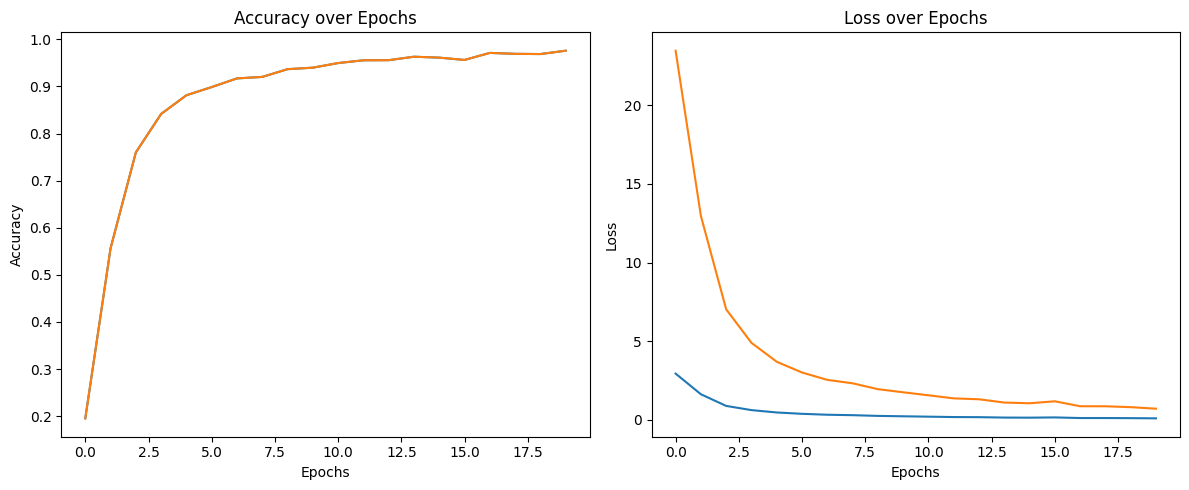

In [17]:
import matplotlib.pyplot as plt  

plt.figure(figsize=(12,5)) 

plt.subplot(1,2,1)
plt.plot(train_accuracies,label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')

plt.subplot(1,2,2)
plt.plot(train_losses,label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')

plt.tight_layout()
plt.show()

## Evaluate the Model

In [18]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
test_loss = running_loss / len(test_loader)
test_acc = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 0.7026, Test Acc: 0.9902


## Save the Model

In [19]:
torch.save(model.state_dict(), 'asl_mediapipe_landmark_model.pth')